In [1]:
%matplotlib widget
%load_ext snakeviz
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/usr/wrk/people9/sima9999/code/")
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import scipy.stats.qmc

from uncertainty.polymorphic_uncertainty import *

%aimport -matplotlib -matplotlib.pyplot -numpy -pandas - scipy.stats -scipy.stats.qmc

In [2]:
def get_deflection_point(alpha,xi, F,l, E,I):
    
    beta = 1-alpha
    xi_ = 1-xi
    
    if xi <=alpha:
        return (1-beta**2-xi**2)*beta*xi*F*l**3/6/E/I
    else:
        return (1-alpha**2-xi_**2)*alpha*xi_*F*l**3/6/E/I

In [3]:
def get_deflection_curve(npoints, alpha, F, l, E, I):
    
    xi_vec = np.linspace(0,1,npoints,True)
    w_vec = np.empty_like(xi_vec)
    
    for i in range(npoints):
        w_vec[i] = get_deflection_point(alpha, xi_vec[i], F, l, E, I)
    
    return w_vec

### Simple example: maximum deflection of a simply supported beam ###

#### Output variable ####

The maximal deflection computed by the defleciton curve

$w(\xi) = (1-\beta^2-\xi^2) \beta \xi \frac{F l^3}{6 E I}$

where $\xi$ is the normalized $x$ coordinate and $\beta$ the point load position as a fraction along the beam


#### Parameters and unvertainties: ####

$\beta = \mathcal{N}(0.0005, 0.00002)$ - aleatory

$F = \mathcal{N}(1000, 40) \text{ N} $- aleatory

$l = 10.000 \text{ mm}$ - deterministic

$E = \mathcal{U}(0,1000)+\{8.000, 11.000\}  \text{ N mm}^{-2}$ - polymorphic

$I=80\times 10^6 \text{ mm}^4$ - deterministic

#### Propagation: ####

is done in an epistemic outerloop, for each focal set in the single epistemic variable and an aleatory inner loop, using Monte Carlo Techniques with $N=10000$

#### Results: ####

 Histograms and scatter plots for each focal set (orange and blue)

(array([4.07670873e-05, 3.80492815e-04, 1.99079276e-03, 5.50355679e-03,
       9.19297819e-03, 9.10804676e-03, 5.36087198e-03, 1.96361471e-03,
       3.80492815e-04, 5.09588591e-05]), array([ 852.75713963,  882.19264947,  911.62815932,  941.06366916,
        970.499179  ,  999.93468884, 1029.37019868, 1058.80570852,
       1088.24121837, 1117.67672821, 1147.11223805]))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
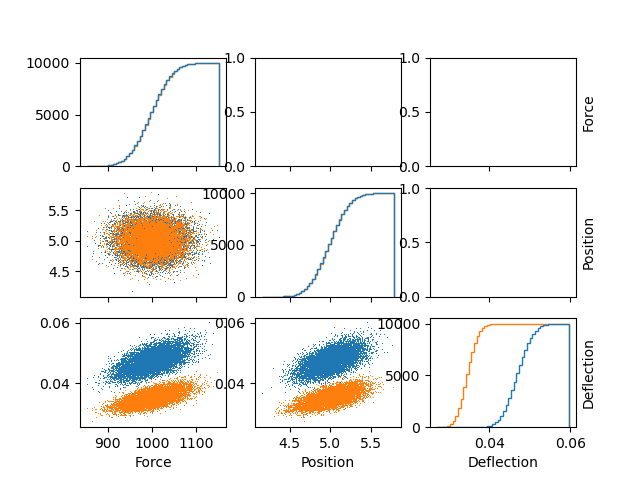

In [4]:
npoints = 25
alpha=.25
F=1000
l=10000
E=11000
I=80e6

nsamples = 10000


mu_F = 1000
var_F = 40
rand_vals= [[],[],[]]

for E in [8000, 11000]:
    E_vec = np.random.rand(nsamples)*1000+E
    F_vec = np.random.randn(nsamples)*var_F+mu_F
    a_vec = np.random.randn(nsamples)*0.2+5

    max_w_monte_carlo = np.empty_like(F_vec)

    for i in range(nsamples):

        w_curve = get_deflection_curve(npoints, a_vec[i]/l, F_vec[i], l, E_vec[i], I)
        max_w_monte_carlo[i] = max(w_curve)
    rand_vals[0].append(F_vec)
    rand_vals[1].append(a_vec)
    rand_vals[2].append(max_w_monte_carlo)
print(np.histogram(F_vec, density=True))

fig, axes = plt.subplots(3,3, sharex='col')

rand_labels = ['Force', 'Position', 'Deflection']
for i in range(3):
    axes[i,i].hist(rand_vals[i], bins=50, cumulative=True, histtype='step')
    for j in range(i):
        axes[i,j].plot(rand_vals[j][0],rand_vals[i][0], ls='none',marker=',')
        axes[i,j].plot(rand_vals[j][1],rand_vals[i][1], ls='none',marker=',')
    axes[-1,i].set_xlabel(rand_labels[i])
    axes[i,-1].yaxis.set_label_position("right")
    axes[i,-1].set_ylabel(rand_labels[i],rotation='vertical',)
plt.show()

### Verification example: analytical/numerical modal analysis ###

System: Vibrating rod, fixed-free boundaries
Input parameters and uncertainties:
- Young's modulus $E$: aleatory - e.g. due to environmental influences (temperature)
- Cross-sectional area $A$: epistemic - e.g. due to manufacturing tolerances
- Mass density $\rho$: aleatory - e.g. due to environmental influences (humidity)
- Length $L$: epistemic - e.g. due to manufacturing tolerances
- Degrees-of-freedom $n$: deterministic
- Rayleigh damping $\alpha$, $\beta$: polymorphic - aleatory due to natural material variability or environment and epistemic due to manufacturing tolerances
- (if needed additionally: boundary conditions)
    
Output parameters:
- modal frequencies: $\omega_1 \ldots \omega_? = \frac{2j-1}{2}\frac{\pi}{L}\sqrt{\frac{E}{\rho}}$
- modal damping: $\zeta_1 \ldots \zeta_? = \zeta = \frac{1}{2}\left(\frac{\alpha}{\omega}+\beta\omega\right) $
- FRF at length $x$ (also includes modeshapes) due to tip excitation: $\mathcal{H}_\mathrm{a}(\omega_\mathrm{f}) = \phi_j(x)\sum_j \frac{-\omega_j^2}{\kappa_j \left(1 + 2.0 i\zeta\frac{\omega_\mathrm{f}}{\omega_j}   - \left(\frac{\omega_\mathrm{f}}{\omega_j}\right)^{2} \right)} $
with $\phi_j(x) = \sin{\left(\frac{2j-1}{2} \frac{\pi}{L} x\right)}$
and $\kappa_j = \omega_j^2$

Proposed method: Second-Order Probability Analysis, two-stage Monte-Carlo Method with Cartesian input mass construction
- three approaches:
    - inner loop epistemic and outer loop aleatory (prefered)
    - inner loop aleatory and outer loop epistemic
    - threefold loops (either way)
    
Steps:
- define input mass and/or probability density functions
- define propagation function
- outer MCS loop: sample aleatory variables according to PDF
    - possibly compute parts of the output, which depend only on aleatory parameters
    - inner MCS loop: 
        - sample epistemic variables according to uniform distribution / regularly spaces?
        - compute output quantities (with aleatory and epistemic parameters)
    - find and store minima and maxima of outputs (could also be done in the inner loop, but better control is possible when precomputing results and postprocessing)
- draw histograms or minima and maxima

In [5]:
def mapping_function(E,A,rho,L,alpha,beta,fs,N,x):
    nyq_omega = fs / 2 * 2 * np.pi
    num_modes_ = int((nyq_omega * L / np.pi / np.sqrt(E / rho) * 2 + 1) // 2)
    
    j = np.arange(1, num_modes + 1, 1)    
    omegans = (2 * j - 1) / 2 * np.pi / L * np.sqrt(E / rho)
    zetas = 0.5 * (alpha / omegans + beta * omegans)
    
    omegas = np.fft.fftfreq(N, 1 / fs) * 2 * np.pi
    frf = np.zeros((N, ), dtype=complex)
    for mode in range(num_modes):
        omegan = omegans[mode]
        kappa = omegan**2
        modal_coordinate = np.abs(np.sin((2 * (mode + 1) - 1) / 2 * np.pi / L * x))
        frf += -omegan**2 / (kappa * (1 + 2 * 1j * zeta * omegas / omegan - (omegas / omegan)**2)) * modal_coordinate
        
    return omegans, zetas, frf    

epistemic parameters -> mass functions:
 - are a number of (focal) sets with associated degrees of belief
 - in the continuous case, sets become intervals or alike functionals defining a range of values, where each value is equally likely to be the "true" value
 - if different degrees of belief are assigned to sub-intervals, multiple subintervals must be defined
 
 - functional: $X \mapsto m$
   - where $X$ is a set or a functional defining a set of numbers, interval, etc. and assigned a mass value $m$ the total mass is assigned to a all $X$ and the remaining to $\Omega$
   
 - sampling: $m \mapsto X$ (select a set $X$ and the corresponding mass $m$)
   - sampling must be thought differently, since we define each focal sets with the intention of using that information,we should not disregard it again by not selecting it in a sampling process, then we could have "asked less experts"
   
 - propagation: 
   - we may choose to:
       - loop over focal sets individually to propagate individual expert knowledge to the output or 
       - combine all focal sets into a (possibly lower) number of new focal sets prior to propagation
   - for each focal set in X:
     - propagate each element in the focal set to $Y$ (or estimate a continuous functional defining $Y$ (e.g. an interval))
     - assign $m_X = m_Y$
     - a mass function: $Y \mapsto m_Y$ is obtained and can be plotted, e.g. as intervals at their respective mass levels
   - multiple inputs $(X_1, X_2, ...) \mapsto Y$:
     - in fuzzy-type mass functions we can define an $\alpha$-level and sample $X_1$, $X_2$, $\ldots$ at their $\alpha$-levels then assign that $\alpha$-level to $Y$
     - for general MassFunctions, all combinations of input focal sets must be computed (Cartesian Product Propagation -> Hypercubes) $A\times B = \{(a,b)\mid a \in A \ \mbox{ and } \ b \in B\}$
       - therefore the number of focal sets for each input should be kept as low ass possible ("ask only 1 to 3 experts")
       - or computer propagate only high-mass hypercubes
       - the mass of the results will be product of the masses of input focal sets
    - for continuous input focal sets, i.e. intervals, continuous output focal sets are assumed -> interval optimization
      - an interval optimization is approximated by Monte Carlo Techniques due to:
        - possibly noise mapping functions
        - multiple outputs
        - multidimensional outputs, that are not directly comparable
        - guaranteed convergence in a limited amount of time
        - the qualitative effect of epistemic uncertainties is more of interest than a highest possible precision of uncertainty propagatio
       - since we assume no value is more or less likely in an input interval, we propagate that assumption to the output intervals, even though the mapping function might lead to different distributions of output values
       - input intervals will be sampled by random distributions to avoid effects related to non-independentness or regular spacing of inputs
         - in order to capture best the behaviour at the interval boundaries an appropriate sampling distribution should be chosen i.e. uniform, arcsine or U-quadratic distribution
    


    
aleatory parameters -> random variables, defined by a PDF/PMF type and parameters
 - these are methods of the 'np.random.rng' Class
 - mass functions are PDFs if their focal sets consist of only singletons and $\sum m_i =1$
 - PDFs can be approximated by Mass functions, by dividing them into several subintervals, however, this will lead to a large number of hypercubes to be propagated 
  
 - functional: 
   - $x \mapsto p$ (defined for every $p \in [0,1]$)
   
 - sampling (using the inverse): 
   - $p \mapsto x$ (where $p$ is a randomly selected number from $[0,1]$)
 - sampling (uniform)
   - obtain the support of the PDF and sample uniform random values 
   - assign probability to each sampled value and pass through propagation 
   - that allows for slight modifications retrocatively
   
 - propagation: 
   - analytical through the mapping function, usually impossible
   - approximation by Monte Carlo Techniques 
       - sample $N$ values from the distribution and propagate them through the mapping function 
       - compute the relevant statistics/Parameters of PDFs from the output samples
   - alternatively using quasi monte carlo techniques
       - sample $N$ values from a uniform distribution on the support and propagate them through the mapping function
       - propagate the probability product of each sample to the output
       - compute weighted statistics/parameters
   

difference:
 - "PMFs/PDFs assign beliefs to singletons/continuous values where MassFunctions assign beliefs to sets/intervals"

polymorphic parameters -> part of the uncertainty is due to natural variablity and another part due to incomplete, imprecise or no knowledge
 - sampling and propagation must take part in the order of the nesting of aleatory and epistemic components
 - in the worst case a threefold nested loop will be required, where only in the innermost loop the full parameter set for the deterministic mapping function will be available, e.g.
   - aleatory (MCS) -> epistemic (interval optimization / MCS) -> aleatory (MCS)
   - epistemic (interval optimization / MCS) -> aleatory (MCS) -> epistemic (interval optimization / MCS)
 - if uniform sampling over the support of each variable is used and probabilities/masses are assigned retroactively
     - samples can be pregenerated: cartesian product of aleatoric and epistemic samples, single parallel loop can be used
     - Number of samples can be extended
     - Support of variables is fixed

 - epistemically uncertain random variables: 
   - the parameter is distributed randomly according to PMF/PDF with parameters x to a certain degree of belief y
   - parameters are defined by mass functions

   - functional:
     - $X \mapsto m$ for all $X \in \Omega$
     - $x \mapsto p$ for all $x \in X$
     
   - sampling:
     - sample parameter(s) from mass function(s)
     - build PDF/PMF
     - sample value vom PDF/PMF

   - propagation:
     - for each focal set:
       - for each value in focal set / interval optimization: (i.o. -> find the values from the focal set that maximize and minize the output)
         - build PMF/PDF
         - for $n_a$ in $N_a$ (Monte Carlo Sampling): 
           - sample value from PMF/PDF
           - propagate through mapping function $Y$
         - compute statistics of interest (mean, var, min, max, other)
       - build output focal set from collected statistics and assign the respective mass to it

 - randomly defined mass functions: 
   - the parameters of a mass function are Random Variables, e.g. the interval boundaries are RVs

   - functional:
     - $X \mapsto p$ for all $X \in \Omega$ ?
     - $x \mapsto m$ for all $x \in X$

   - sampling:
     - sample parameter(s) x from RandomVariable(s) X
     - build focal set and assign a mass to it (how to choose this mass?)
     - sample value from focal set

   - propagation:
     - for $n_a$ in $N_a$ (Monte Carlo Sampling):
       - sample parameters from RandomVariables
       - build focal set and assign a mass to it (how to choose this mass?)
       - for each value in focal set / interval optimization:
         - propagate through mapping function $Y$
       - build output focal set from output values and assign the respective mass to it
     - compute statistics over the focal sets, e.g. histograms of interval boundaries (masses act as weights?)
  
  - randomly defined mass functions that define a random variable:
    - the equivalent of "Fuzzy probability based fuzzy random variable"
     
distinguish:

probability space: $(\Omega, \Sigma, P)$ (define the set of all values, the set of all subset (or continuous intervals) of all values, and a probability measure)

Random Variable: $X: \Omega \mapsto \mathbb{R}$ (picks a single value fom $\Omega$)

Probability measure: $P_X: \mathcal{B}(\mathbb{R}) \mapsto [0,1]: I \mapsto P_X(I) = P(X^{-1}[I])$ (assign each element/set in $\Sigma = \mathcal{B}(\mathbb{R})$ (?) a number in $[0,1]$)

Probability density function: $P_X(I) = \int_I f_X(t)d(t)$ (actually $f_X$ is the pdf )

'\ncreate example with ~20 focals\nshowing the properties below:\naligned non-cumulative/not-aligned many non-cumulative/not-aligned few cumulative\n\n\npl == q if bins are aligned with focal sets\nq <= pl if bins are not aligned with focal sets\nbel <= q <= pl \nfor large focal sets / small bins bel is mostly 0\n\nfor cumulative measures \nq is mostly 0 (useless measure)\nbel < pl for overlapping focal sets\n'

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
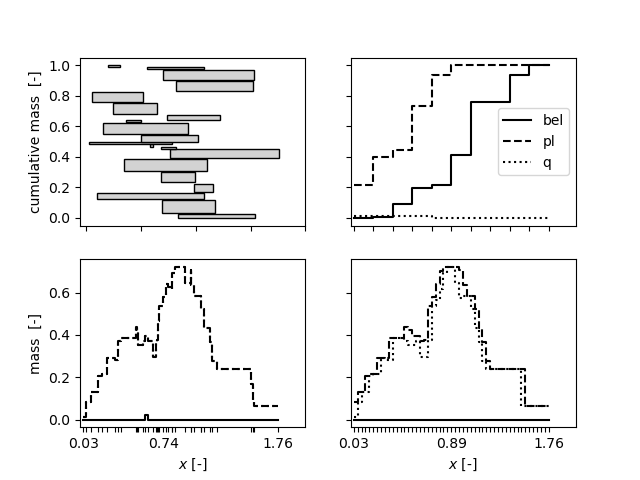

In [36]:
random_sets = True
sort=False
nfocals=20
cumulative = False
nbins = None # set None to use aligned bins

if not random_sets:
    mass = np.diff([0,0.4,0.7,1.3,1.7,2.7,3,3.6,3.8,4,4.2,4.5])
    focals = np.array([(0.7,3),(1.2,4),(1.3,1.8),(1.7,3.3),(0.7,4.8),(1.7,4.3),(2.4,3.9),(3,3.7),(3.3,5.1),(1.2,3.7),(2.5,3.2)])
    nfocals = mass.size
else:
    mass = np.random.random(nfocals)
    focals = np.empty((nfocals,2))
    focals[:,0] = np.random.random(nfocals)
    focals[:,1] =  focals[:,0] + np.random.random(nfocals)

if sort:
    sortinds = np.flip(np.argsort(mass))
    mass =mass[sortinds]
    focals = focals[sortinds,:]
    
mass /= mass.sum()

# plot focal sets and masses
fig, axes = plt.subplots(2,2, sharex=False, sharey='row')
ax1,ax2,ax3,ax4 = axes.ravel()

def plot_focals(focals, mass, ax=None):
    if ax is None: _,ax = plt.subplots()
    cm=0
    for (l,r),m in zip(focals,mass):  
        ax.bar(l,m*0.9,(r-l),bottom = cm+0.05*m, align='edge', color='lightgrey', edgecolor='black')
        cm += m
    ax.set_xticks([0,0.5,1,1.5,2])
    ax.set_xticklabels(['','','','','',])
    
    return ax

plot_focals(focals, mass, ax1)
    
for nbins, cumulative, ax in zip([None, 51, 11], 
                                 [False, False, True], 
                                 [ax3, ax4, ax2]):
        

    bins, bel, pl, q = compute_belief(focals, mass, cumulative,nbins)
#     ax.vlines(bins, 0, 1, color='grey', ls='dashed',  lw=1)
#     bel = np.zeros(bins.size)
#     pl = np.zeros(bins.size)
#     q = np.zeros(bins.size)

#     # Bins are set A
#     # focals are set B or C
#     for i in range(bins.size - 1):
#         # set A
#         lbin, ubin = bins[i:i+2]
#         if cumulative:
#             lbin = focals.min()

#         # get all sets B that are a subset of A
#         # that means the lower boundary of B must be greater or equal than the lower boundary of A
#         # and similarly for the upper boundary
#         belinds = np.logical_and(focals[:,0] >=lbin,
#                                  focals[:,1] <= ubin)
#         bel[i] = np.sum(mass[belinds])
#         # get all sets B that intersect with A
#         # that means the lower boundary of B must not be higher (= must be strictly lower) than the upper boundary of A (B entirely outside of A to the right)
#         # and the upper boundary of B must not be lower (= must be strictly higher) than the lower boundary of A (B  entirely outside of A to the left)
#         plinds = np.logical_and(focals[:,0]<ubin, 
#                                 focals[:,1]>lbin, )
#         pl[i] = np.sum(mass[plinds])

#         # get all sets B that are a superset of A   (=A is a subset of B)
#         # that means the lower boundary of A must be greater or equal to the lower boundary of B
#         # and similarly for the upper boundary
#         qinds = np.logical_and(focals[:,0] <= lbin,
#                                focals[:,1] >= ubin)   
#         q[i] = np.sum(mass[qinds])

#     bel[-1]=bel[-2]
#     pl[-1]=pl[-2]
#     q[-1]=q[-2]
    
#     print(np.sum(pl[:-1]*np.diff(bins)), np.sum(q[:-1]*np.diff(bins)), np.sum(bel[:-1]*np.diff(bins)))

    
    ax.step(bins, bel, c='k', where='post', label='bel', ls='solid')
    ax.step(bins, pl, c='k', where='post', label='pl', ls='dashed')
    ax.step(bins, q, c='k', where='post', label='q', ls='dotted')
    ax.set_xlim((0,2))
    ax.set_xticks(bins)
    ticklabels= ['' for _ in range(bins.size)]
    ticklabels[0] = f'{bins[0]:1.2f}'
    ticklabels[-1] = f'{bins[-1]:1.2f}'
    ticklabels[bins.size//2] = f'{bins[bins.size//2]:1.2f}'
    ax.set_xticklabels(ticklabels)
                
ax2.legend()
ax2.set_xticklabels(['' for _ in ax2.get_xticks()])
ax1.set_ylabel('cumulative mass  [-]')
ax3.set_ylabel('mass  [-]')
ax3.set_xlabel('$x$ [-]')
ax4.set_xlabel('$x$ [-]')
# ax1.set_title('focal sets')
# ax2.set_title('cumulative belief functions (few regular bins)')
# ax3.set_title('belief functions (aligned bins)')
# ax4.set_title('belief functions (many regular bins)')


'''
create example with ~20 focals
showing the properties below:
aligned non-cumulative/not-aligned many non-cumulative/not-aligned few cumulative


pl == q if bins are aligned with focal sets
q <= pl if bins are not aligned with focal sets
bel <= q <= pl 
for large focal sets / small bins bel is mostly 0

for cumulative measures 
q is mostly 0 (useless measure)
bel < pl for overlapping focal sets
'''

### Types of uncertainty and how to model them: ###

#### variability: ####
  * description: natural variation of a parameter, which cannot be reduced 
  * modeling: assuming exact description of variability properties -> probability distributions, 
  * outcome: (single loop: aleatory)
      * estimate statistics: most likely value + confidence intervals, probabilities of exceedance, 
      * bin the output and for each bin compute the probaility density
  * visualization: 
      * tables for scalar values
      * empirical CDFs (histograms), 
  
#### incompleteness: ####
  * description: approximate knowledge of the variability properties, distribution parameters can not be exactly determined due to insufficient number of samples
  * modeling: assume different ranges for distribution parameters to which we assign mass (=degree of belief)
  * outcome (outer loop: epistemic, inner loop: aleatory):     
      * for each epistemic sample
          * evaluate aleatory samples to get scalar or multi-valued (probability densities on bins) statistics
      * for each input hypercube
          * do interval optimization on the scalar / multi-valued statistics and assign mass
      * bin the statistics and for each bin
          * compute bel, pl and q (how much mass supports precisely the bin)
  * visualization: 
      * bar plots for statistics width=mass
      * plot bel, pl and q of scalar statistics
      * plot histograms with pl/q as colormap on the probability axis (similar to upper and lower probabilities (pboxes))

#### imprecision: ####
  * description: approximate knowledge of a parameter, which is assumed invariable, due to imprecise measurements
  * modeling: choose different ranges and assign degrees of belief
  * outcome: (single loop: epistemic)
      * ranges on the output with associated masses (for each input hypercube)
      * bin the output space and compute bel, pl and q functions on these bins
  * visualization (see example below): 
      * horizontal bar plots on the ranges and width = mass (sums up to 1) (one bar for each input hypercube)
      * plot bel, pl and q  

#### additional types of uncertainty: ####
  * vagueness, (fuzzyness OR epistemicist view: vague predicates do, in fact, draw sharp boundaries, but that one cannot know where these boundaries lie)
  * ambiguity,  (outcomes are unknown, because one can not predict which outcome will be realized, more research may increase uncertainty, new evidence will contradict existing knowledge)
  * indeterminacy,  (causal chains are open, opposed to determinacy; complexity of what is studied, existence of nonlinear relations, knowledge can not be used to make predictions, systemic changes, )
  * Ignorance (unknown outcomes - we don't knwo what we don't know [Black swan problem, Faulty generalization])
  * dubiety, (a generally hesitant uncertainty or doubt that tends toward indecision / to cause vacillation )
  * subjective experience, 
  * expert knowledge,    

### Modeling strategies for combined types of uncertainty / polymorphic uncertainty as defined by TU DD Group: ###

#### VAR + IMP (Fuzzy-Randomness): ####
  * description: a range of values, whose boundaries are variable
  * modeling: define a probability distribution, which operates on sets/ranges
  * outcome: 
      * estimate set-valued statistics: 
          * most likely set/range + confidence intervals (how?),  
          * probabilities of exceedance (how?), 
          * bin counts (how?), 
          * etc.
      * that all requires sets to be orderable -> fuzzy sets
  * simplification/alternative: sets which are bound by probability distributions
  * outcome (outer loop: aleatory, inner loop: epistemic): 
      * uncertain bel, pl and q curves (fixed bins, variable values)
      * for each aleatory sample
          * for each epistemic sample in the hypercube
              * do interval optimization on the output quantity and assign mass
          * bin the output and for each bin
              * compute bel, pl and q
      * compute statistics for bel, pl and q and each epistemic bin
  * visualization: 
      * plot bel, pl and q with vertical lines color shading proportional to probability density


#### VAR + INC (Fuzzy probability based randomness): ####
  => incompleteness
  
#### INC + VAR + IMP (Fuzzy-probability based fuzzy randomness): ####
  * description: a range of values, whose boundaries are variable and incompletely known
  * define variables by name that may reference others (polymorphic)
  * assign propagation_stages to variables:
      pure epistemic (imprecision): stage_3
      pure aleatory (variability): stage_2
      epistemic + aleatory (incompleteness): stage_1 (stage 2)
      aleatory + epistemic:: stage_2 (stage 3)
  * compute support/frame of each variable to define the **sample space**
  * Building a 2D or a 3D sample space?
      * 3D: individually sample incomplete, variable and imprecise variabels and combine them full-focatorial
          * for each aleatory sample an interval optimization is to be performed
          * for each epistemic sample a monte carlo simulation is to be performed
          * that means in a threefold loop we choose an epistemic sample, then choose an aleatory sample and need a sufficient number of epistemic samples again to do the inner loop interval optimization
          * a threefold nesting of low-discrepancy sequences is required according to the stages of the variables
      
      * 2D: since we consolidate foc_imp and foc_inc we should be able to "simulate" the both epistemic loop in a single run
      * Example: 
          * sample incomplete variables and supplement a sample of imprecise variables
          * perform MCS on aleatory variables and store the CDF
          * go to the next sample
          * eventually we cover the whole range of incomplete and imprecise variables and have a CDF for each sample
          * which is presumably not much different from the original approach but much more efficient
      * try that with the example from Pannier
  * assign id_ale and id_epi to respective samples for storing intermediate results (see below)
  * Further performance improvements:
  * reuse independent steps of the mapping function
  * define steps of the mapping function e.g. structural dynamics, signal processing, system identification and modal analysis
  * make the first step(s) pure aleatory is the only option here since all further steps depend on uncertain input from the previous steps which will not be pure aleatory or pure epistemic anymore then; 
      * uncertain inputs: 
          * noise excitation is unknown and random (aleatory random field + process),
          * noise excitation amplitude can be estimated roughly (incomplete output but aleatory input), 
          * impulse excitation DOFs are known to some extent by the pracitioner, but their relation to the modeshapes can only be estimated roughly (define an imprecise modeshape relation), 
          * impulse excitation spectra depend on the hammer tip, the impact point stiffness and other factors and can be rouhgly estimated from the datasheets (define a probability distribution on the excitation spectrum, the choice of an appropriate spectrum out of a few is however imprecise), 
          * impulse times are modeled as a random process (aleatory)
      * certain inputs (exemplary evaluation for different structures: rod, beam, 3D beam, nonlinear rod, nonlinear 3D beam)
          * mass, stiffness, damping (rayleigh)
          * number of nodes (system order)
          * deltat (small enough -> downsampling in signal processing)
          * timesteps (enough -> shorten in sig-proc)
          * output DOFs (all -> reduce in sig-proc)
          * nonlinearities (together with uncertain inputs will result in uncertain (linearized) system properties)
    

#### POST-PROCESSING computed output samples ####
  * construct incomplete variables (from polymorphic inputs, INC does not exist for pure epistemic) -> V_inc
  * **evaluate incompleteness** (Interval optimization Part I)
      * sample monomorphic variables -> S_inc
      * sample distribution parameters (polymorphic variables) 
      * construct random variables (from pure aleatory and polymorphic inputs) -> V_var
      * **evaluate variability** (Monte Carlo Simulation)
          * sample random values monomorphic variable -> S_var
          * sample random values polymorphic variables 
          * construct imprecise variables (from pure epistemic and polymorphic inputs) -> V_imp
          * **evaluate imprecision** (IO Part I)
              * sample imprecise variables -> S_imp
              * evaluate mapping function S_inc, S_var, S_imp -> S_out[N_mcs_epi, n_out]
          * for each hypercube in V_imp (IO Part II) -> n_hyc_imp
              * compute intervals/focal sets of output (for n_out variables in S_out)
              * assign mass product
          * -> Mass_imp [n_hyc_imp, n_out]
          * -> Foc_imp [n_hyc_imp, 2, n_out]
      * (MCS Part II)compute statistic on each Foc_imp (All_Foc_Imp [N_mcs_ale, n_hyc_imp, 2, n_out] e.g. 
          * upper and lower average output value n_stat=1
          * upper and lower confidence intervals of output value n_stat=2
          * upper and lower failure probability n_stat=1
          * upper and lower probability density for each aleatory bin n_stat=20
          * **Problem**: Probability weights get lost/mixed up in previous interval optimization, even though, they only depend on the outermost loop, in 2D sampling innermost and outermost loop are combined
      * -> Stat_Foc_imp [n_stat * n_hyc_imp, 2, n_out]
   * for each hypercube in V_inc (Interval optimization Part II) -> n_hyc_inc
       * compute intervals/focal sets of each n_stat statistic for each boundary of each hypercube in n_hyc_imp
       * assign mass product
   * -> Foc_inc_Stat_Foc_imp [n_hyc_inc * n_stat * n_hyc_imp, 2_inc , 2_imp , n_out]
   * -> Mass_inc x Mass_imp [n_hyc_inc * n_hyc_imp,  n_out ]
   * consolidate imp-inc hypercubes?
       * now, we have for each of the n_hyc_inc hypercubes twice (upper_inc, lower_inc) a number of n_hyc_imp statistics (e.g. failure probabilities, CDF curves) twice (upper_imp, lower_imp)
       * let's consider the interval length as sensitivity with regard to the input hypercube sens_.. = upper_.. - lower_..
       * cases: (per epistemic hypercube)
           * no imprecision: upper_imp==lower_imp
           * no incompleteness: upper_inc==lower_inc
           * no variability: statistic==const. (this does not matter here)
           * sens_imp > sens_inc OR sens_inc > sens_imp OR sens_inc~sens_imp: 
               * in any case low-low / high-high are the boundaries and low-high / high-low move in between
       * -> reduce to low-low / high-high + sens_imp / sens_inc
       * n_hyc_cons = n_hyc_inc * n_hyc_imp
   * Foc_Stat_cons [n_hyc_cons * n_stat , 2 , n_out]
   * (Sens_imp [n_hyc_cons * n_stat , n_out], Sens_inc  [n_hyc_cons * n_stat , n_out])
   * derive other belief functions:
   * for each stat in n_stat: (e.g. for each aleatory bin)
       * bin the range of stat (e.g. range of mean values, range of failure probabilities, range of probability densities)
       * (possibly use the same bins for comparable statistics)
       * for each bin:
           * compute bel, pl and q form the n_hyc_cons hypercubes and corresponding Mass_cons values
           * for cumulative statistics -> use non-cumulative belief functions
           * for non-cumulative statistics -> use cumulative belief functions
       * plot belief functions of scalar statistics
   * plot multi-valued statistics with belief function color shading
   
   * special cases to consider (later):
       * in case of no variability: only imprecision Foc_Stat_cons = Stat_Foc_imp = Foc_imp
       * in case of no imprecision: Foc_imp = S_out
       * in case of no incompleteness: -> see no variability
           
      
      
What is of interest here is:
   * outer-most loop: incompleteness leads to intervals of distributed interval valued outputs
   * middle loop: variability leads to distributed interval valued outputs
   * inner-most loop: imprecision leads to interval valued outputs
   * in total: families of distributed interval valued outputs
   * inner-most loop: for each imprecise input hypercube -> compute belief function (interval boundaries :-> mass)
   * middle loop: alternatives
       * compute the distribution of the interval boundaries (for each imprecise input hypercube) (distributed interval boundaries -> mass)
       * compute bel,pl,q for bins distributed over output range; compute distributions of bel,pl,q for each bin
   * outer-most loop: for each incomplete input hypercube -> compute the upper and lower probability distribution of each interval boundary of imprecise input hypercubes (-> mass product)
    
   * n_inc x n_imp upper and lower probabilities 
 das

### Examples from Pannier et al. ###

mapping: $f(q_1,q_2) = (\frac{189}{500} q_1 + 3 q_2) \frac{16}{3} > 260 $

number of Monte Carlo samples: 1 000 000

In [2]:
def deterministic_mapping(q1,q2,sigma_max=260):
    return deterministic_mapping2(q1,q2)>sigma_max
def deterministic_mapping2(q1,q2):
    return (189/500*q1+3*q2)*16/3
N_mcs = int(1e6)

### example a) variability ###

In [10]:
example_num = 0

q1 = RandomVariable(name='q1', dist='norm', params=[15, 4], primary=True)
q2 = RandomVariable(name='q2', dist='norm', params=[8, 2], primary=True)

dim_ex='cartesian'

vars_ale = [q1,q2]
vars_epi = []
arg_vars = {'q1':'q1', 'q2':'q2'}

### example b) variability + imprecision ###
#### interval optimization approximation with quasi MCS ####

In [17]:
example_num = 1

inc_q1a1 = (RandomVariable(name='q1', dist='norm', params=[15,4], primary=False), # set same name to share input samples
           -0.05,
           0.05)
inc_q1a0 = (inc_q1a1[0],
            RandomVariable(name='q1a0l', dist='norm', params=[-0.4,0.1], primary=False), 
            RandomVariable(name='dq1a0r', dist='norm', params=[0.5,0.06], primary=False))
q1 = MassFunction(name='q1', focals=[inc_q1a1, inc_q1a0], masses=[0.5,0.5], primary=True, incremental=True)

inc_q2a1 = (RandomVariable(name='q2', dist='norm', params=[8,2], primary=False), # set same name to share input samples
           -0.05,
           0.05)
inc_q2a0 = (inc_q2a1[0],
            RandomVariable(name='dq2a0l', dist='norm', params=[-0.6,0.08], primary=False), 
            RandomVariable(name='dq2a0r', dist='norm', params=[0.4,0.11], primary=False))
q2 = MassFunction(name='q2', focals=[inc_q2a1, inc_q2a0], masses=[0.5,0.5], primary=True, incremental=True)

dim_ex='cartesian'

vars_ale = [*inc_q1a0,*inc_q2a0]
vars_epi = [q1, q2]
arg_vars = {'q1':'q1', 'q2':'q2'}

### example c) variability + incompleteness ###
#### interval optimization approximation with quasi MCS ####
  

In [3]:
example_num = 2

mu1 = MassFunction(name='mu1', focals=[(14.79,14.79),(13.96,15.61)], masses=[0.5,0.5], primary=False)
sig1 = MassFunction(name='sig1', focals=[(4.17,4.17),(3.66,4.85)], masses = [0.5, 0.5], primary=False)
q1 = RandomVariable(name='q1', dist='norm', params=[mu1, sig1])

mu2 = MassFunction(name='mu2', focals=[(8.1,8.1),(7.67,8.52)], masses=[0.5,0.5], primary=False)
sig2 = MassFunction(name='sig2', focals=[(2.14,2.14),(1.88,2.48)], masses = [0.5, 0.5], primary=False)
q2 = RandomVariable(name='q2', dist='norm', params=[mu2, sig2])

dim_ex='cartesian'

vars_epi = [mu1,sig1, mu2, sig2]
vars_ale = [q1, q2]
arg_vars = {'q1':'q1', 'q2':'q2'}

### example d) variability + incompleteness + imprecision ###
#### interval optimization approximation with quasi MCS ####

In [3]:
example_num = 3

q1a1mu    = MassFunction(name='q1a1mu',    focals=[(14.62,      ), (13.8, 15.45)], masses=[0.5,0.5],  primary=False)
q1a1sig   = MassFunction(name='q1a1sig',   focals=[(4.16 ,      ), (3.65, 4.83)], masses=[0.5,0.5],   primary=False)
q1a1      = RandomVariable(name='q1',    dist='norm', params=[q1a1mu, q1a1sig], primary=False)

dq1a0lmu  = MassFunction(name='dq1a0lmu',  focals=[(-0.41,      ), (-0.46, -0.38)], masses=[0.5,0.5],  primary=False)
dq1a0lsig = MassFunction(name='dq1a0lsig', focals=[( 0.10,      ), ( 0.09,  0.12)], masses=[0.5,0.5],  primary=False)
dq1a0l    = RandomVariable(name='dq1a0l',  dist='norm', params=[dq1a0lmu, dq1a0lsig], primary=False)

dq1a0rmu  = MassFunction(name='dq1a0rmu',  focals=[( 0.50,      ), ( 0.49,  0.52)], masses=[0.5,0.5],  primary=False)
dq1a0rsig = MassFunction(name='dq1a0sig',  focals=[( 0.06,      ), ( 0.05,  0.08)], masses=[0.5,0.5],  primary=False)
dq1a0r    = RandomVariable(name='dq1a0r',  dist='norm', params=[dq1a0rmu, dq1a0rsig], primary=False)

q1        = MassFunction(name='q1', focals=[(q1a1, 0, 0), (q1a1, dq1a0l, dq1a0r)], masses=[0.5,0.5], primary=True, incremental=True)

q2a1mu    = MassFunction(name='q2a1mu',   focals=[(8.10,     ), (7.67, 8.52)], masses=[0.5,0.5],  primary=False)
q2a1sig   = MassFunction(name='q2a1sig',  focals=[(2.12,     ), (1.86, 2.46)], masses=[0.5,0.5],   primary=False)
q2a1      = RandomVariable(name='q2',   dist='norm', params=[q2a1mu, q2a1sig], primary=False)

dq2a0lmu  = MassFunction(name='dq2a0lmu',  focals=[(-0.59,      ), (-0.61, -0.57)], masses=[0.5,0.5],  primary=False)
dq2a0lsig = MassFunction(name='dq2a0lsig', focals=[( 0.08,      ), ( 0.07,  0.09)], masses=[0.5,0.5],  primary=False)
dq2a0l    = RandomVariable(name='dq2a0l',  dist='norm', params=[dq2a0lmu, dq2a0lsig], primary=False)

dq2a0rmu  = MassFunction(name='dq2a0rmu',  focals=[(0.40,     ), (0.38, 0.42)], masses=[0.5,0.5],  primary=False)
dq2a0rsig = MassFunction(name='dq2a0sig',  focals=[(0.10,     ), (0.09, 0.12)], masses=[0.5,0.5],  primary=False)
dq2a0r    = RandomVariable(name='dq2a0r',  dist='norm', params=[dq2a0rmu, dq2a0rsig], primary=False)

q2        = MassFunction(name='q2', focals=[(q2a1,     ), (q2a1, dq2a0l, dq2a0r)], masses=[0.5,0.5], primary=True, incremental=True)

dim_ex='hadamard'

vars_epi = [q1a1mu, q1a1sig, dq1a0lmu, dq1a0lsig, dq1a0rmu, dq1a0rsig, q1,
            q2a1mu, q2a1sig, dq2a0lmu, dq2a0lsig, dq2a0rmu, dq2a0rsig, q2]
vars_ale = [q1a1, dq1a0l, dq1a0r,
            q2a1, dq2a0l, dq2a0r,]
arg_vars = {'q1':'q1', 'q2':'q2'}

### example e) mixed aleatory and epistemic primary variables ###

In [4]:
example_num = 4

mu1 = MassFunction(name='mu1', focals=[(14.79,14.79),(13.96,15.61)], masses=[0.5,0.5], primary=False)
sig1 = MassFunction(name='sig1', focals=[(4.17,4.17),(3.66,4.85)], masses = [0.5, 0.5], primary=False)
q1 = RandomVariable(name='q1', dist='norm', params=[mu1, sig1])

inc_q2a1 = (RandomVariable(name='q2', dist='norm', params=[8,2], primary=False), # set same name to share input samples
           -0.05,
           0.05)
inc_q2a0 = (inc_q2a1[0],
            RandomVariable(name='dq2a0l', dist='norm', params=[-0.6,0.08], primary=False), 
            RandomVariable(name='dq2a0r', dist='norm', params=[0.4,0.11], primary=False))
q2 = MassFunction(name='q2', focals=[inc_q2a1, inc_q2a0], masses=[0.5,0.5], primary=True, incremental=True)

dim_ex='cartesian'
vars_epi = [mu1,sig1, q2]
vars_ale = [q1, *inc_q2a0]
arg_vars = {'q1':'q1', 'q2':'q2'}

In [4]:
# %%snakeviz
N_mcs_ale = 1000
N_mcs_epi = 1000

poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
poly_uq.sample_qmc(N_mcs_ale, N_mcs_epi, check_sample_sizes=False)
poly_uq.propagate(deterministic_mapping2, arg_vars)
pass

Generating low-discrepancy sequences for all variables... 
Generating grid...
Propagating mapping function...
Mapping function was called 1000 times in a pure aleatory loop.
Done... 


In [6]:
# %%snakeviz
if False:
    fig = plt.figure()
else:
    fig=None
intervals = poly_uq.estimate_imp(False)
#p_weights = poly_uq.probabilities_imp()
#hyc_mass = poly_uq.imp_hyc_mass
#n_imp_hyc = len(hyc_mass)
#seed = poly_uq.seed

....................................................................................................


In [13]:
#%%snakeviz

def stat_fun(a, weight, i_stat):
    exceed = a>=260
    return np.sum(weight[exceed])

# def stat_fun(a, weight,):
#     return [np.average(a, weights=weight),]


n_stat = 1
# focals_Pf, hyc_mass = poly_uq.estimate_inc(intervals, stat_fun, n_stat)
focals_Pf, hyc_mass = poly_uq.optimize_inc(stat_fun, n_stat)

if example_num==0: # Example 1
    print(f'Result: \t {focals_Pf[0,0,0]*1e4} - {focals_Pf[0,0,1]*1e4}')
    print('Reference:\t 10.03 - 10.03')
elif example_num==1: # Example b
    print("Alpha-level 1 (Hypercube 0)")
    print(f'Result: \t {focals_Pf[0,0,0]*1e4} (- {focals_Pf[0,0,1]*1e4})')
    print('Reference:\t 10.27')
    
    print("Alpha-level 0 (Hypercube 3)")
    print(f'Result: \t {focals_Pf[0,3,0]*1e4} - {focals_Pf[0,3,1]*1e4}')
    print('Reference:\t 3.21 - 21.94')
elif example_num==2: # Example c
    print("Alpha-level 1 (Hypercube 0)")
    print(f'Result: \t {focals_Pf[0,0,0]*1e4} (- {focals_Pf[0,0,1]*1e4})')
    print('Reference:\t 20.10')
    
    print("Alpha-level 0 (Hypercube 15)")
    print(f'Result: \t {focals_Pf[0,15,0]*1e4} - {focals_Pf[0,15,1]*1e4}')
    print('Reference:\t 2.33 - 120.16')
else:
    n_hyc = len(hyc_mass)
    for i_hyc in range(n_hyc):
        print(f"(Hypercube {i_hyc})")
#         print(f'Result: \t {focals_Pf[0,i_hyc,0]*1e4} - {focals_Pf[0,i_hyc,1]*1e4}')
        print(f'Result: \t {focals_Pf[0,i_hyc,0]*1e4} - {focals_Pf[0,i_hyc,1]*1e4}')
    '''
    Hypercube     Hypercube Imp     Hypercube Inc
    0             0 (precise)       0 (complete)      alpha=1, beta=1  19.12 -  19.12
    1             0 (precise)       1 (incomplete)    alpha=1, beta=0   1.66 - 111.55
    2             1 (imprecise)     0 (complete)      alpha=0, beta=1   7.6  -  37.07
    3             1 (imprecise)     1 (incomplete)    alpha=0, beta=0   0.54 - 183.12
    missing       (consolidated with hyc 3)           alpha=0, beta=0   4.29 -  53.56
     '''
    
        

....................................................................................................
Alpha-level 1 (Hypercube 0)
Result: 	 22.569712837211064 (- 22.569712837211064)
Reference:	 20.10
Alpha-level 0 (Hypercube 15)
Result: 	 2.2076949144986946 - 124.52382671726721
Reference:	 2.33 - 120.16


In [35]:
#%%snakeviz

def stat_fun(a, weight, i_stat, bins_densities, cum_dens):
    '2. Quantify Variability for each incomplete sample and imprecise hypercube'
    if i_stat is None:
        hist,_ = np.histogram(a, bins_densities, weights=weight, density=True)

        if cum_dens:
            hist= np.cumsum(hist)
            hist /= hist[-1]   
        return hist
    else:
        # factor 6 faster but more error prone for "dirty" data, uneven bins or ....
        if cum_dens: first_edge = bins_densities[0]
        else: first_edge = bins_densities[i_stat]
        last_edge = bins_densities[i_stat + 1]
        keep  = (a >= first_edge)
        keep &= (a <=  last_edge)
        return np.sum(weight[keep])
        
        


nbin_fact=20
n_imp_hyc = len(poly_uq.imp_hyc_foc_inds)
bins_densities = generate_histogram_bins(intervals.reshape(N_mcs_ale, n_imp_hyc * 2), 1, nbin_fact/2) # divide nbin_fact by 2 to account for reshaping intervals
n_stat = len(bins_densities) - 1
cum_dens = True
stat_fun_kwargs = {'bins_densities':bins_densities, 'cum_dens':cum_dens}#, 'ax':ax1}

# focals_densities, hyc_mass = poly_uq.estimate_inc(intervals, stat_fun, n_stat, stat_fun_kwargs)
focals_densities, hyc_mass = poly_uq.optimize_inc(stat_fun, n_stat, stat_fun_kwargs)


In [36]:
bel_densities, pl_densities, q_densities = aggregate_mass(focals_densities, hyc_mass, 20, False)
n_bins_bel = bel_densities.shape[1]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
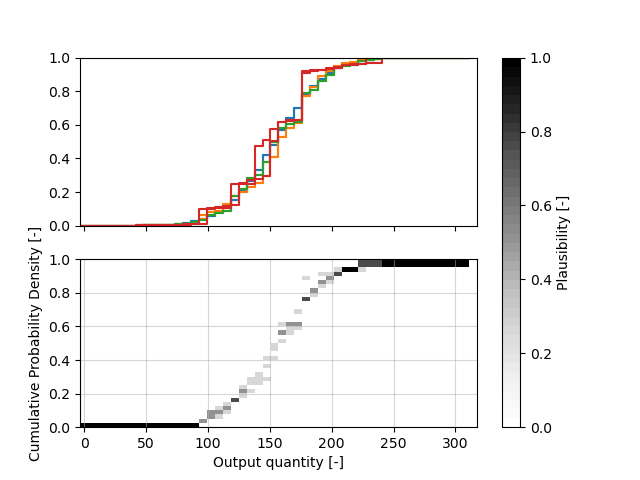

In [37]:

bpq=2

fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,sharey=True)   

for i_hyc in range(hyc_mass.shape[0]):
    l2d=ax1.step(bins_densities[:-1], focals_densities[:,i_hyc, 0], where='post')
    c = l2d[0].get_color()
    ax1.step(bins_densities[:-1], focals_densities[:,i_hyc, 1], where='post', color=c)

if bpq == 1:
    belief = bel_densities.T
    label = 'Belief [-]'
elif bpq == 2:
    belief = pl_densities.T
    label = 'Plausibility [-]'
elif bpq == 3:
    belief = q_densities.T
    label = 'Commonality [-]'

cmap = matplotlib.cm.get_cmap('Greys', n_bins_bel)
im = ax2.imshow(belief, aspect='auto', extent= (bins_densities[0], bins_densities[-1], 0, 1), 
           cmap=cmap, origin='lower', vmin=0, vmax=1)

cbar = fig.colorbar(im, ax=[ax1,ax2])
cbar.set_label(label)

ax2.grid(True, alpha=0.5)
ax2.set_xlabel("Output quantity [-]")

if cum_dens:
    ax2.set_ylabel("Cumulative Probability Density [-]")
else:
    ax2.set_ylabel("Probability Density [-]")    

In [39]:
'''
MCS vs QMCS
'''
qmc = False
i_hyc = 3

out_ivs=np.zeros((N_mcs_ale,2))
p_weights2 = np.ones((N_mcs_ale))
for n_ale in  range(N_mcs_ale):
    if not n_ale%100: print('.', end='')
    
    if qmc:
        # freeze the aleatory variables
        this_in = samples_ale.iloc[n_ale]
        for var in vars_ale:
            var.freeze(this_in[var.name])
            p_weights2[n_ale] *= var.mass(this_in[var.name])
    else:
        for var in vars_ale:
            var.freeze(var.rvs(size=1)[0])
    # get uncertain intervals
    focq1 = q1.numeric_focals[hyc_foc_inds[i_hyc][0]]
    focq2 = q2.numeric_focals[hyc_foc_inds[i_hyc][1]]
    
    # Interval Optimization -> Linear mapping (optimum obtained directly)
    out_ivs[n_ale, :] = [ deterministic_mapping2(focq1[0], focq2[0]), deterministic_mapping2(focq1[1], focq2[1])]
    
p_weights2 /= np.sum(p_weights2)
out_ivs_fail = out_ivs>260

....................................................................................................

3.0000000000000004 19.000000000000004


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
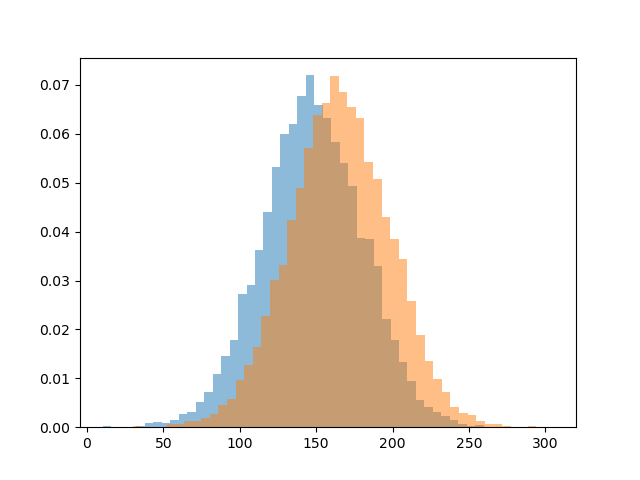

In [ ]:
plt.figure()
plt.hist(out_ivs[:,0], bins=50, weights=p_weights2, alpha=0.5)
plt.hist(out_ivs[:,1], bins=50, weights=p_weights2, alpha=0.5)
print(np.sum(p_weights2[out_ivs_fail[:,0]])*1e4, np.sum(p_weights2[out_ivs_fail[:,1]])*1e4)

 * convergence study for all examples (performance and memory usage as well)
 * multi-output mappings
 * own example
 * 